In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [2]:
x_original=pd.read_csv('../../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../../_targelable4_withNa_AllColumns.txt')

x_original=x_original[['Unnamed: 0','L100800', 'L104600', 'SEX', 'AGE', 'L101300', 'S000300', 
                       'L103000', 'L103300', 'S000501', 'S000502', 'L101700', 'FIELD_38',
                      'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24']]

y_original=y_original[['Unnamed: 0','L100800']]


print(x_original.shape)
print(y_original.shape)


(159381, 19)
(159381, 2)


In [3]:
for index,col in enumerate(x_original.columns):
    print(col,x_original[col].dropna().shape[0])

Unnamed: 0 159381
L100800 159236
L104600 56437
SEX 159381
AGE 159381
L101300 159247
S000300 159075
L103000 158939
L103300 135222
S000501 159305
S000502 159305
L101700 158951
FIELD_38 159077
FIELD_16 159363
FIELD_23 159365
FIELD_15 159361
FIELD_22 159365
FIELD_17 159364
FIELD_24 158934


Prepare the data
============

In [4]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

print(data.shape)

(48933, 21)


In [5]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia
print(data.shape)

(48933, 21)


In [6]:
print(data.shape)
print(data.columns)
data.head()

(48933, 21)
Index(['index', 'Unnamed: 0', 'L100800_x', 'L104600', 'SEX', 'AGE', 'L101300',
       'S000300', 'L103000', 'L103300', 'S000501', 'S000502', 'L101700',
       'FIELD_38', 'FIELD_16', 'FIELD_23', 'FIELD_15', 'FIELD_22', 'FIELD_17',
       'FIELD_24', 'L100800_y'],
      dtype='object')


,index,Unnamed: 0,L100800_x,L104600,SEX,AGE,L101300,S000300,L103000,L103300,...,S000502,L101700,FIELD_38,FIELD_16,FIELD_23,FIELD_15,FIELD_22,FIELD_17,FIELD_24,L100800_y
0,2,2,78.0,5.28,1.0,46.0,10.0,20.2,41.0,3.4,...,82.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0
1,4,4,90.0,5.74,1.0,52.0,12.0,25.5,50.0,2.9,...,65.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0
2,7,7,86.0,5.83,1.0,37.0,5.0,21.2,45.0,2.9,...,61.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0
3,8,8,86.0,4.73,1.0,39.0,15.0,22.0,54.0,3.1,...,77.0,30.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0
4,30,30,99.0,5.10,1.0,19.0,9.0,20.1,92.0,2.6,...,60.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0


In [7]:

x=data[['L100800_x', 'L104600', 'SEX', 'AGE', 'L101300', 'S000300', 
                       'L103000', 'L103300', 'S000501', 'S000502', 'L101700', 'FIELD_38']]

y=data[['L100800_y' ]]

Check the correlation of the selected feature with the independent variables
=====

In [8]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.L100800_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [9]:
corval.y

y            1.000000
L100800_x    0.666891
L104600      0.557616
S000300      0.294059
L103000      0.283171
L103300      0.269159
SEX          0.259208
S000501      0.252344
L101700      0.242579
S000502      0.224483
L101300      0.202544
AGE          0.200614
FIELD_38     0.159373
Name: y, dtype: float64

In [10]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [11]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [12]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [13]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [14]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [15]:
# x.columns

Random Forest Regressor
=============

In [16]:
ylable=y[['L100800_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [17]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.7285962  0.15275978 0.01679586 0.01410889 0.01720002 0.01619998
 0.00854846 0.00875109 0.00848687 0.00819446 0.01616255 0.00419584]


mean_squared_error 79.37942222890298
root mean_squared_error 8.909513018616842
mean_absolute_error 6.237881918487659
r2_score 0.5175503635008539


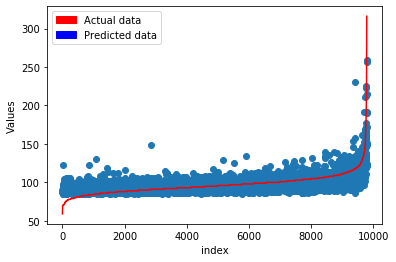

,t + 1,pred (t +1)
1380,221.0,190.564087
635,224.0,191.169205
779,233.0,256.779674
7261,234.0,148.581989
1667,236.0,150.620825
6635,237.0,123.271543
3540,282.0,259.313718
8130,306.0,214.390749
3841,310.0,172.525253
608,316.0,121.072251


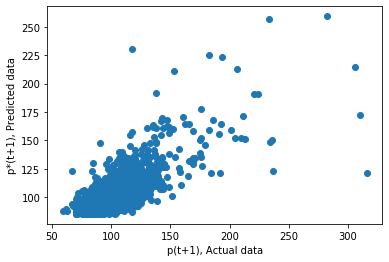

In [18]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [19]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [26]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [27]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[09:04:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [28]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 68.33732786413722
root mean_squared_error 8.266639454103295
mean_absolute_error 6.102586759249207
r2_score 0.4930284305782344


In [29]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=34,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)